In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras

import bayesflow as bf

from memilio.simulation.abm import forward_pass 

INFO:2026-02-01 01:16:57,349:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:bayesflow:Using backend 'jax'
c:\Users\nilsw\OneDrive\Dokumente\GitHub\memilio_abm\pycode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
RNG = np.random.default_rng(2025)

def prior():
    """Generates a random draw from the joint prior."""

    beta = RNG.lognormal(mean=np.log(0.08), sigma=0.5)
    eps = RNG.uniform(low=2, high=10)
    return {"beta": beta, "eps": eps}

def abm(beta, eps):
    data = forward_pass(beta, eps)
    data = data
    return dict(cases=data)

simulator = bf.make_simulator([prior, abm])
test_sims = simulator.sample(batch_size=2)


test_sims = simulator.sample(batch_size=2)

print(test_sims["beta"].shape)
print(test_sims["cases"].shape)


(2, 1)
(2, 31, 11)


In [26]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("cases")
    .concatenate(["beta", "eps"], into="inference_variables")
    .rename("cases", "summary_variables")
    # since all our variables are non-negative (zero or larger), the next call transforms them
    # to the unconstrained real space and can be back-transformed under the hood
    .log(["inference_variables", "summary_variables"], p1=True)
)

In [27]:
adapted_sims = adapter(simulator.sample(2))
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(2, 31, 11)
(2, 2)


In [28]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""
        #print("GRU input shape:", time_series.shape)
        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        #print(summary.shape)
        return summary
    
summary_net = GRU()

In [29]:
inference_net = bf.networks.CouplingFlow()

In [30]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    standardize=None # no need to standardize due to log-transform
)

In [31]:
training_data = workflow.simulate(20000)
validation_data = workflow.simulate(1000)


In [32]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=100, 
    batch_size=64, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: -0.0677 - val_loss: -1.9357
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: -2.0845 - val_loss: -2.1066
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: -2.1973 - val_loss: -2.2547
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: -2.2161 - val_loss: -2.3323
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: -2.2331 - val_loss: -2.3100
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: -2.3486 - val_loss: -2.3882
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: -2.4254 - val_loss: -2.4743
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: -2.4666 - val_loss: -2.4973
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: -2.5162 - val_loss: -2.5080
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: -2.5284 - val_loss: -2.3700
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: -2.5591 - val_loss: -2.44

INFO:bayesflow:Training completed in 16.80 minutes.


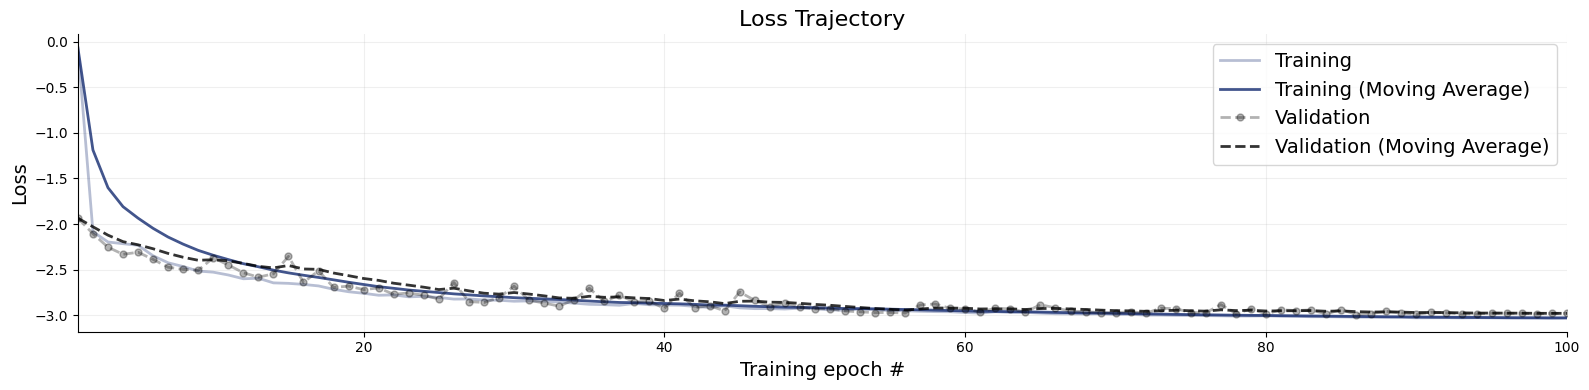

In [33]:
f = bf.diagnostics.plots.loss(history)

In [34]:
# Set the number of posterior draws you want to get
num_datasets = 300
num_samples = 1000

# Simulate 300 scenarios
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)

Sampling: 100%|██████████| 1/1 [00:02<00:00,  2.50s/batch]
INFO:bayesflow:Sampling completed in 2.68 seconds.


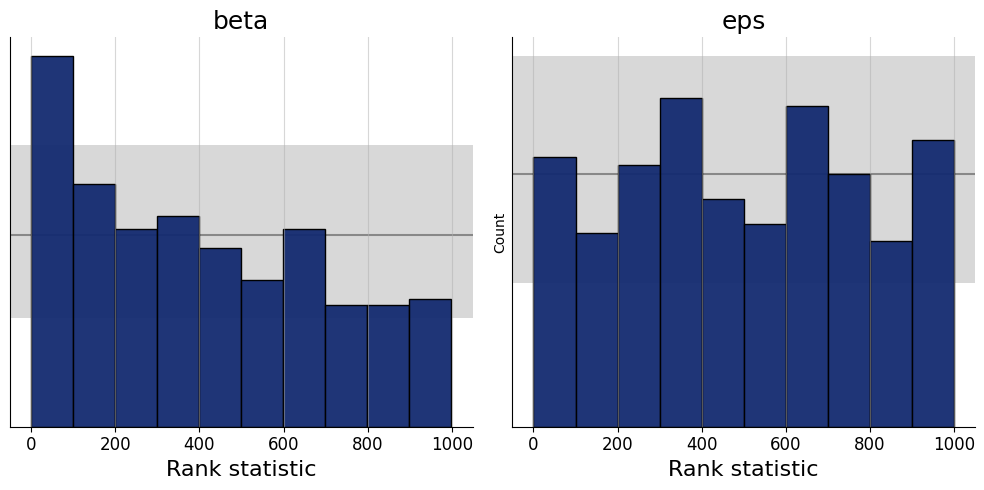

In [35]:
f = bf.diagnostics.plots.calibration_histogram(samples, test_sims)

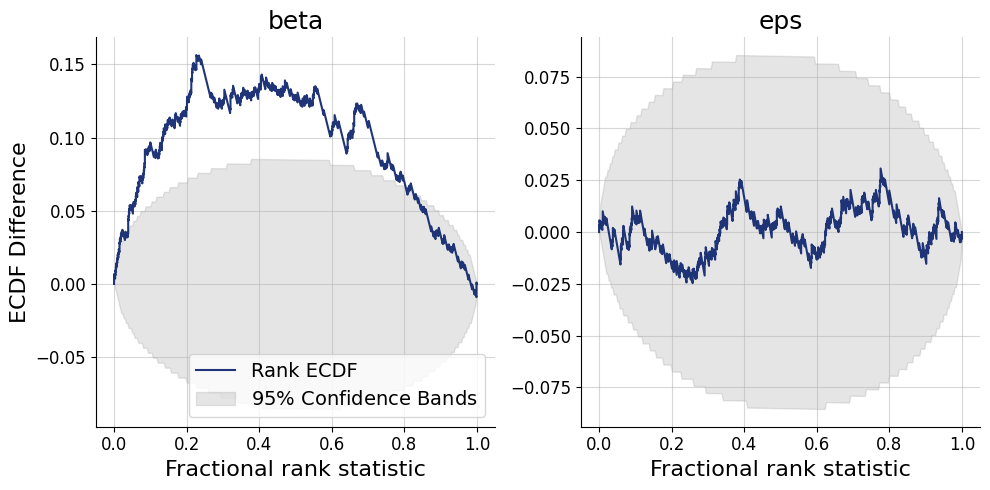

In [36]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

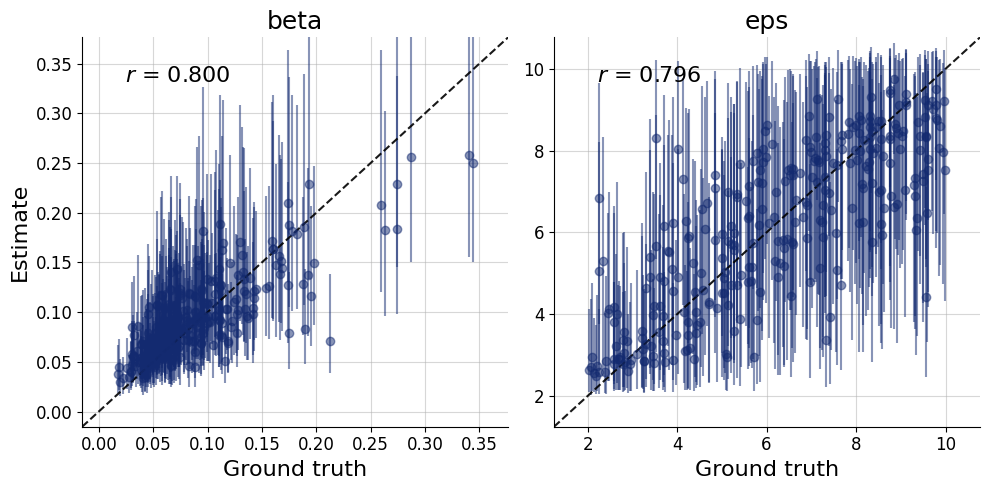

In [37]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

Sampling: 100%|██████████| 1/1 [00:01<00:00,  1.81s/batch]
INFO:bayesflow:Sampling completed in 1.94 seconds.


(200, 1000, 1)


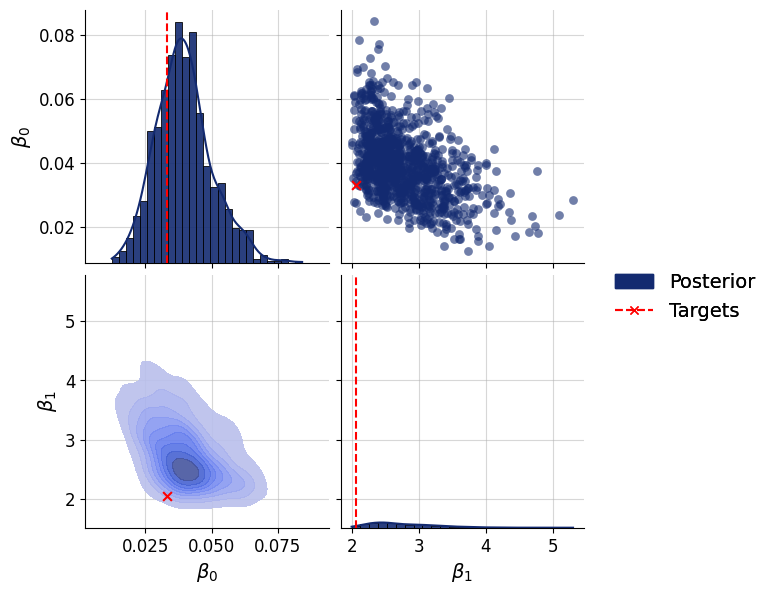

In [39]:
par_names = [r"$\beta_0$", r"$\beta_1$"]
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data (unseen during training)
val_sims = simulator.sample(200)

# Obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()
print(post_draws["beta"].shape)
post_draws["beta"].min()
f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=0,
    variable_names=par_names,
)